## Overfitting: Learns training data too well, fails on new data.
Here's how my friends know it by in different fields:
* Bias-Variance Tradeoff issue — Actuary friend
* Overinterpretation — Doctor friend
* Model “hallucination” or false positives — Doctor friend
* Poor generalization — Doctor Friend
* Too specific to the training data — Machine learning friend
* High variance / low robustness - Data Science Friend
* Over-tuning / overtraining - Engineering Friend

Overfitting is often easier to understand through a graph than through words (see below).
* The black line represents an overfitted model — it memorizes the training data.
* The blue line shows a simple linear regression — it underfits by being too simple.

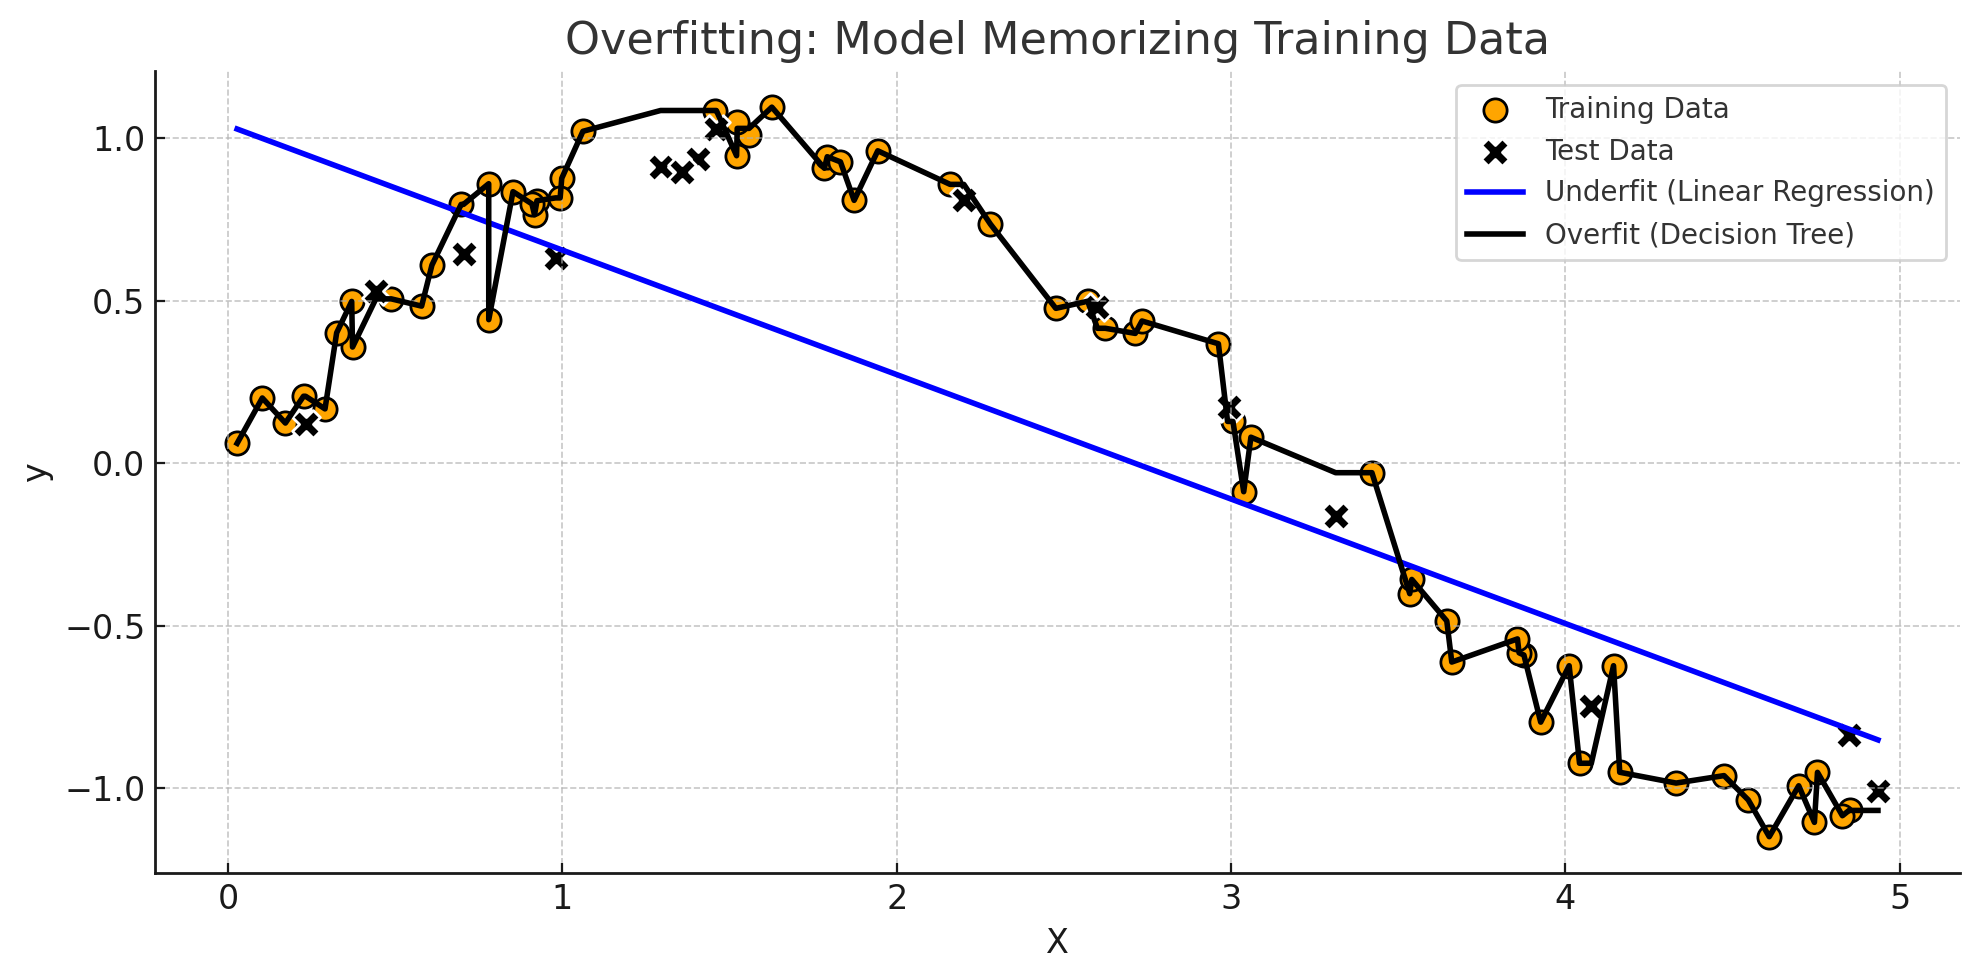

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Read the datasets
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")
gender_submission = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")

# Optional: Show the shapes to confirm they're loaded
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("Gender submission shape:", gender_submission.shape)

Train shape: (891, 12)
Test shape: (418, 11)
Gender submission shape: (418, 2)


## Decision Tree will Overfit Titanic Data:
Decision trees are known to overfit data because they are greedy algorithms. 
The tree has to split sometimes even if it not exactly sure when and without thinking ahead.
Even on a simple Titanic dataset, the tree will overfit quickly:
* Fewer than 900 passengers in training data.
* Decision trees can easily memorize small datasets.
* This looks good on training data but fails on new data (overfitting).

In [2]:
# Define the required features
required_cols = ['Pclass', 'Sex', 'Age', 'Fare', 'Parch', 'PassengerId', 'SibSp']

# Filter to only those columns + 'Survived'
train_df = train_df[required_cols + ['Survived']]

# Encode categorical 'Sex' to numeric
train_df['Sex'] = train_df['Sex'].map({'male': 0, 'female': 1})

# Fill missing values with column medians
train_df = train_df.fillna(train_df.median(numeric_only=True))

# Define features and target
X = train_df[required_cols]           # input features
y = train_df['Survived']              # target variable

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

max_depth_num = 6
# Overfitted decision tree
tree_model = DecisionTreeClassifier(
    max_depth=max_depth_num,           # No limit → overfit
    min_samples_split=2,      # Allows tiny splits
    min_samples_leaf=1,       # Allows leaves with one row
    random_state=42
)
tree_model.fit(X_train, y_train)

# Accuracy
train_acc = accuracy_score(y_train, tree_model.predict(X_train))
test_acc = accuracy_score(y_test, tree_model.predict(X_test))

print("Overfitted Decision Tree:")
print("Train Accuracy:", round(train_acc, 3))
print("Test Accuracy:", round(test_acc, 3))

gap = train_acc - test_acc
print("Accuracy Gap:", round(gap, 3))

Overfitted Decision Tree:
Train Accuracy: 0.882
Test Accuracy: 0.799
Accuracy Gap: 0.083


### Overfits
Not only doing the data overfit, the data becomes not readable literally.

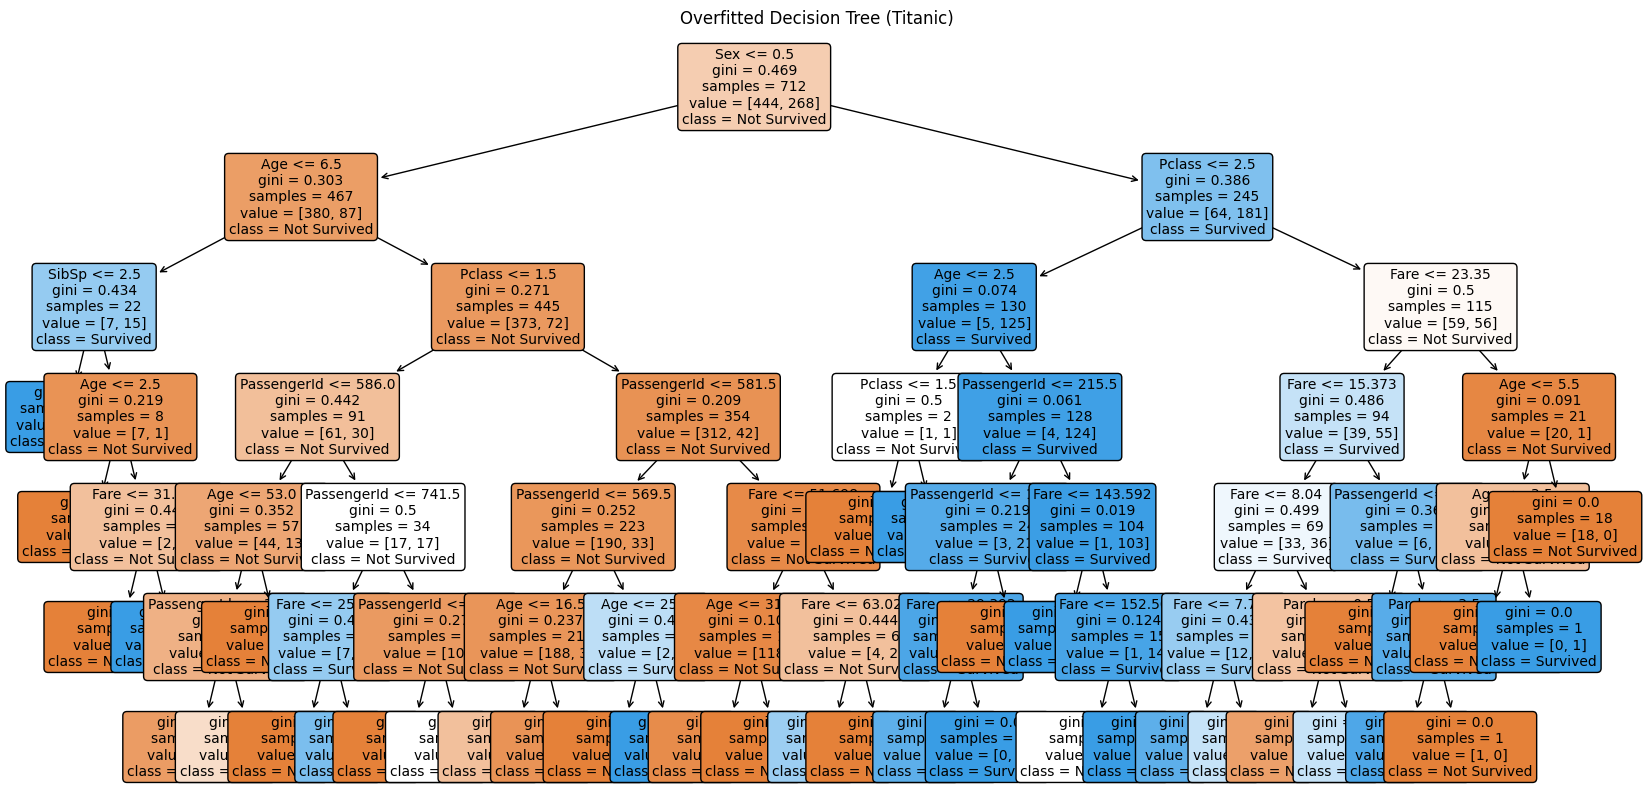

In [3]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Set figure size
plt.figure(figsize=(20, 10))

# Plot the decision tree
plot_tree(tree_model, 
          feature_names=X.columns, 
          class_names=['Not Survived', 'Survived'], 
          filled=True, 
          rounded=True, 
          fontsize=10)

plt.title("Overfitted Decision Tree (Titanic)")
plt.show()

In [4]:
# Step 1: Select only the needed columns
test_df = test_df[required_cols]  # filter out unwanted columns

# Step 2: Encode 'Sex'
test_df['Sex'] = test_df['Sex'].map({'male': 0, 'female': 1})

# Step 3: Fill missing values with column median
test_df = test_df.fillna(test_df.median(numeric_only=True))

# Step 4: Save PassengerId for submission
passenger_ids = test_df['PassengerId']

# Step 5: Prepare features (must match training columns in same order)
X_features = test_df[required_cols]  # includes PassengerId if it was in training

# Step 6: Predict
test_predictions = tree_model.predict(X_features)

# Step 7: Create submission file
output = pd.DataFrame({
    'PassengerId': passenger_ids,
    'Survived': test_predictions
})
output.to_csv('submission.csv', index=False)
print("Submission file saved successfully")

Submission file saved successfully


## Tunned Paramter Decision Tree

Train Accuracy: 0.834
Test Accuracy: 0.799
Accuracy Gap: 0.035


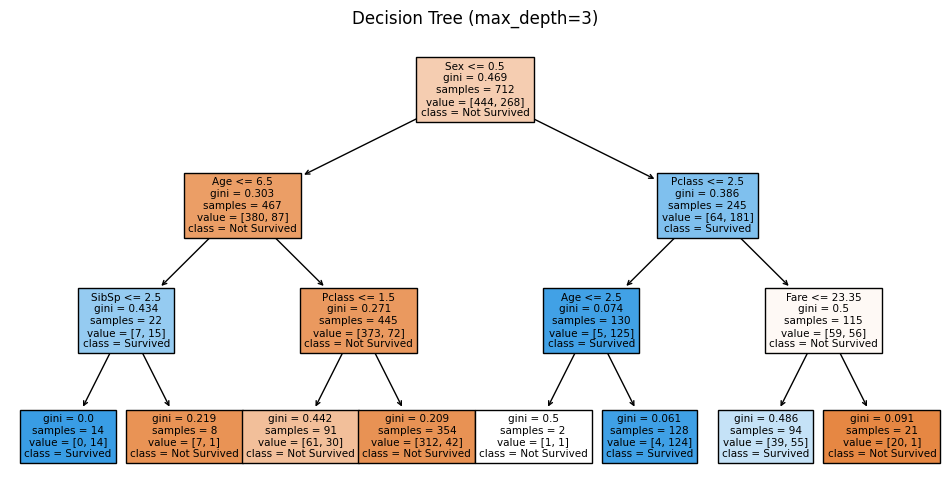

In [5]:
tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_model.fit(X_train, y_train)

# Accuracy
train_acc = accuracy_score(y_train, tree_model.predict(X_train))
test_acc = accuracy_score(y_test, tree_model.predict(X_test))

print("Train Accuracy:", round(train_acc, 3))
print("Test Accuracy:", round(test_acc, 3))
print("Accuracy Gap:", round(train_acc - test_acc, 3))

# Visualize
plt.figure(figsize=(12, 6))
plot_tree(tree_model, feature_names=X.columns, class_names=['Not Survived', 'Survived'], filled=True)
plt.title("Decision Tree (max_depth=3)")
plt.show()

## Tune Max Depth Tree
Tuning the max_depth improves the AUC from 0.75 to 0.79, but the improvement is relatively small — suggesting the model may still be limited in capturing deeper patterns.

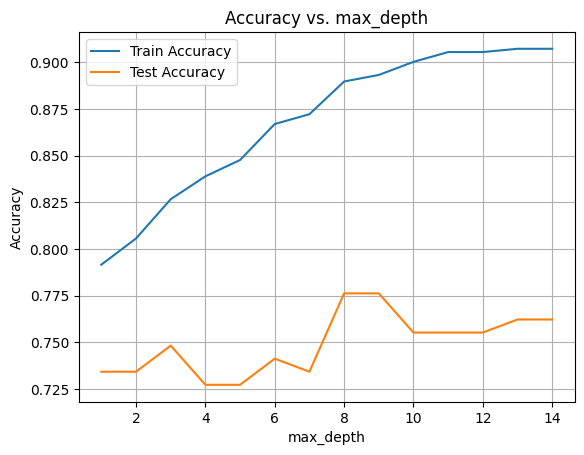

In [6]:
# Load and clean data
df = pd.read_csv("/kaggle/input/titanic/train.csv")
df = df[['Survived', 'Pclass', 'Sex', 'Age']].dropna()
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

X = df[['Pclass', 'Sex', 'Age']]
y = df['Survived']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Try different max_depth values
depths = range(1, 15)
train_scores = []
test_scores = []

for depth in depths:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    train_scores.append(accuracy_score(y_train, model.predict(X_train)))
    test_scores.append(accuracy_score(y_test, model.predict(X_test)))

# Plot results
plt.plot(depths, train_scores, label='Train Accuracy')
plt.plot(depths, test_scores, label='Test Accuracy')
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. max_depth")
plt.legend()
plt.grid(True)
plt.show()

## Solution 
* The (easy) solution to get accurate, reliable for the Titanic data will be to use XGboost or random forest.
* This will be my next video seeing if I can improve my top 5% Titanic score from a few years ago (this was before ChatGPT!):
https://github.com/ScottySchmidt/MachineLearning/blob/main/Titanic.ipynb